# import data

In [19]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


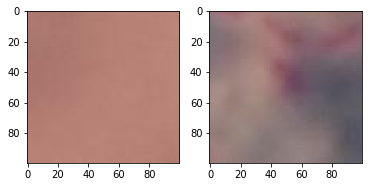

In [20]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.int)
X_val = X_val.astype(np.int)
y_train = y_train.astype(np.int)
y_val = y_val.astype(np.int)

# change into one-hot vector
y_train = tf.keras.utils.to_categorical(y_train, 2) 
y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

## Define trainning function

In [3]:
def train_data(model):
    loss = []
    acc = []
    val_loss = []
    val_acc = []
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
    hist = model.fit(X_train, y_train,
                     batch_size=64,
                     epochs=50,  # Run thru all the data point in each epoch
                     verbose=1,
                     validation_data=(X_val, y_val),
                     #callbacks=[tensorboard])
                     callbacks=[early_stop, tensorboard])
    #val_err.append(hist.history['val_mean_absolute_error'][-1]) # a dict
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
    acc.append(hist.history['acc'][-1])
    val_acc.append(hist.history['val_acc'][-1])   
    
    return loss, val_loss, hist

## Define a VGG network

In [4]:
def VGG(activ):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=activ, input_shape=(100, 100, 3)),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation=activ),
        tf.keras.layers.Dense(4096, activation=activ),
        tf.keras.layers.Dense(1000, activation=activ),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    param = model.count_params()
    model.compile(optimizer=tf.train.AdamOptimizer(0.000001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
   

    model.summary()
    
    return model, param

## Define a DNN model

In [25]:
def dnnmodel(n, activ):
    param = []
    model = tf.keras.Sequential([])
    model.add(tf.keras.layers.Flatten(input_shape=(100, 100, 3)))
    for i in range(n):
        model.add(tf.keras.layers.Dense(100, activation=activ))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    # model.summary()
    # model.count_params()
    param.append(model.count_params())
    model.compile(optimizer=tf.train.AdamOptimizer(0.000001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'mae'])
    return model, param

## Trainning with VGG

### VGG with activation "relu"

In [6]:
activ = 'relu'
model_VGG1, param_VGG1 = VGG(activ)
loss_VGG1, val_loss_VGG1, hist_VGG1= train_data(model_VGG1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 256)       590080    
_________________________________________________________________
max_

### Define the function for plots

In [11]:
def plot_acc_and_loss(hist):
    acc = hist.history['acc']
    loss = hist.history['loss']
    val_acc = hist.history['val_acc']
    val_loss = hist.history['val_loss']
    
    plt.plot(acc, 'r-o')
    plt.title("Trainning accuracy")
    plt.show()
    
    plt.plot(loss, 'g-o')
    plt.title("Trainning loss")
    plt.show()
    
    plt.plot(val_acc, 'b-o')
    plt.title("Validation accuracy")
    plt.show()
    
    plt.plot(val_loss, 'm-o')
    plt.title("Validation loss")
    plt.show()

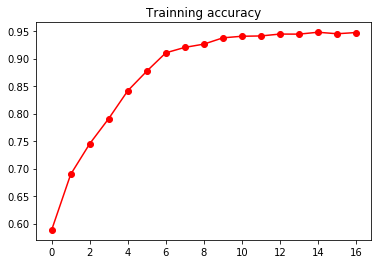

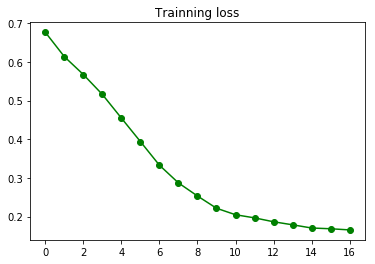

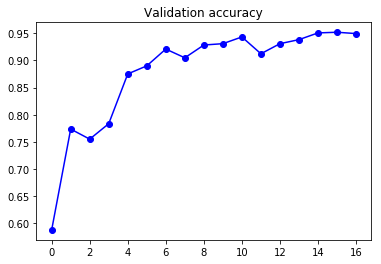

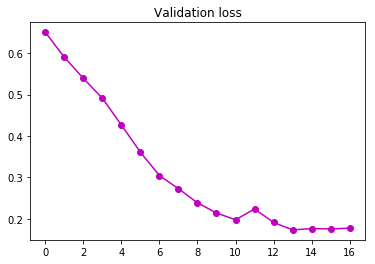

In [12]:
plot_acc_and_loss(hist_VGG1)

### Calculate sensitivity and specificity

In [15]:
from sklearn.metrics import confusion_matrix

predictions = model_VGG1.predict(X_val)
y_val = np.argmax(y_val, axis=-1)
predictions = np.argmax(predictions, axis=-1)
c = confusion_matrix(y_val, predictions)
print('Confusion matrix:\n', c)
print('sensitivity', c[0, 0] / (c[0, 1] + c[0, 0]))
print('specificity', c[1, 1] / (c[1, 1] + c[1, 0]))

Confusion matrix:
 [[428  29]
 [ 12 339]]
sensitivity 0.936542669584245
specificity 0.9658119658119658


### VGG with activation "relu"

In [21]:
activ = 'tanh'
model_VGG2, param_VGG2 = VGG(activ)
loss_VGG2, val_loss_VGG2, hist_VGG2= train_data(model_VGG2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 256)       590080    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 256)       0         
__________

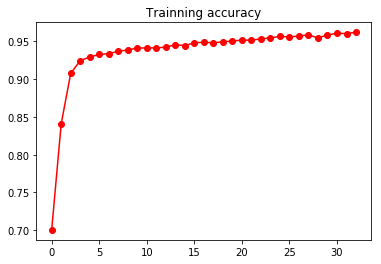

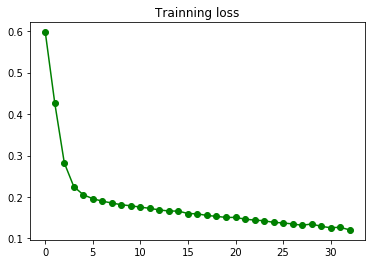

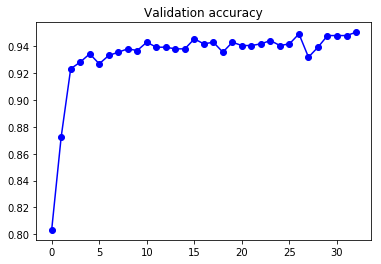

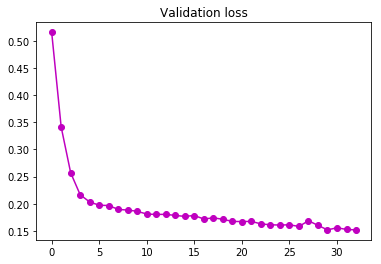

In [22]:
plot_acc_and_loss(hist_VGG2)

In [23]:
predictions = model_VGG2.predict(X_val)
y_val1 = np.argmax(y_val, axis=-1)
predictions = np.argmax(predictions, axis=-1)
c = confusion_matrix(y_val1, predictions)
print('Confusion matrix:\n', c)
print('sensitivity', c[0, 0] / (c[0, 1] + c[0, 0]))
print('specificity', c[1, 1] / (c[1, 1] + c[1, 0]))

Confusion matrix:
 [[450  18]
 [ 22 318]]
sensitivity 0.9615384615384616
specificity 0.9352941176470588


## DNN

In [29]:
activ = 'relu'
model_DNN, param1_DNN = dnnmodel(15, activ)
loss_DNN, val_loss_DNN, hist_DNN= train_data(model_DNN)

Train on 7268 samples, validate on 808 samples
Epoch 1/50
7268/7268 [==============================] - 2s 258us/sample - loss: 0.9049 - acc: 0.5663 - mean_absolute_error: 0.4582 - val_loss: 0.7027 - val_acc: 0.5792 - val_mean_absolute_error: 0.4607
Epoch 2/50
7268/7268 [==============================] - 1s 194us/sample - loss: 0.6930 - acc: 0.5663 - mean_absolute_error: 0.4657 - val_loss: 0.6696 - val_acc: 0.5792 - val_mean_absolute_error: 0.4636
Epoch 3/50
7268/7268 [==============================] - 1s 192us/sample - loss: 0.6710 - acc: 0.5663 - mean_absolute_error: 0.4636 - val_loss: 0.6516 - val_acc: 0.5792 - val_mean_absolute_error: 0.4555
Epoch 4/50
7268/7268 [==============================] - 1s 195us/sample - loss: 0.6483 - acc: 0.5663 - mean_absolute_error: 0.4545 - val_loss: 0.6432 - val_acc: 0.5792 - val_mean_absolute_error: 0.4626
Epoch 5/50
7268/7268 [==============================] - 1s 199us/sample - loss: 0.6302 - acc: 0.5691 - mean_absolute_error: 0.4462 - val_loss: 0.

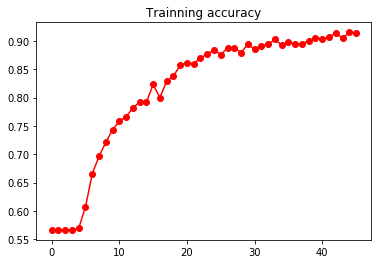

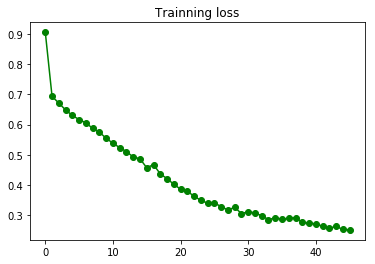

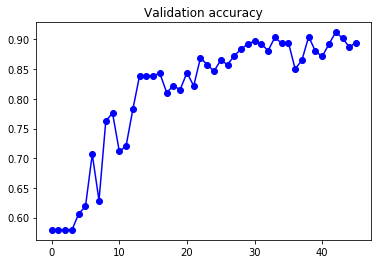

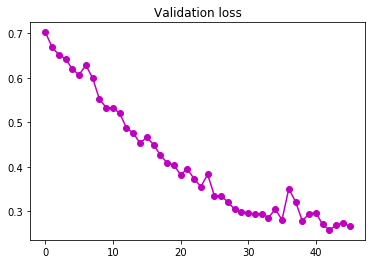

In [30]:
plot_acc_and_loss(hist_DNN)

In [31]:
predictions = model_DNN.predict(X_val)
y_val1 = np.argmax(y_val, axis=-1)
predictions = np.argmax(predictions, axis=-1)
c = confusion_matrix(y_val1, predictions)
print('Confusion matrix:\n', c)
print('sensitivity', c[0, 0] / (c[0, 1] + c[0, 0]))
print('specificity', c[1, 1] / (c[1, 1] + c[1, 0]))

Confusion matrix:
 [[448  20]
 [ 65 275]]
sensitivity 0.9572649572649573
specificity 0.8088235294117647


## ResNet

In [33]:
from tensorflow.keras.applications import ResNet50

def resnet():
    input_tensor = tf.keras.layers.Input(shape=(100, 100, 3))
    model = ResNet50(include_top=True, weights=None, input_tensor=input_tensor, input_shape=None, pooling=None, classes=2)
    param = model.count_params()
    model.compile(optimizer=tf.train.AdamOptimizer(0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model, param

In [34]:
model_resnet, param_resnet = resnet()
loss_resnet, val_loss_resnet, hist_resnet= train_data(model_resnet)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 50, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Epoch 1/50
7268/7268 [==============================] - 20s 3ms/sample - loss: 0.8414 - acc: 0.5226 - val_loss: 5.0843 - val_acc: 0.4257
Epoch 2/50
7268/7268 [==============================] - 15s 2ms/sample - loss: 0.6607 - acc: 0.6037 - val_loss: 0.7429 - val_acc: 0.6027
Epoch 3/50
7268/7268 [==============================] - 15s 2ms/sample - loss: 0.6399 - acc: 0.6222 - val_loss: 0.6663 - val_acc: 0.6002
Epoch 4/50
7268/7268 [==============================] - 15s 2ms/sample - loss: 0.6131 - acc: 0.6588 - val_loss: 0.6293 - val_acc: 0.6436
Epoch 5/50
7268/7268 [==============================] - 15s 2ms/sample - loss: 0.5861 - acc: 0.6874 - val_loss: 0.6077 - val_acc: 0.6559
Epoch 6/50
7268/7268 [==============================] - 15s 2ms/sample - loss: 0.5532 - acc: 0.7166 - val_loss: 0.5871 - val_acc: 0.6795
Epoch 7/50
7268/7268 [==============================] - 15s 2ms/sample - loss: 0.5242 - acc: 0.7397 - val_loss: 0.5886 - val_acc: 0.6943
Epoch 8/50
7268/7268 [===================

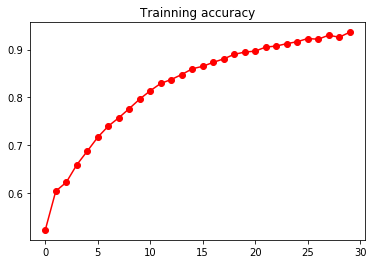

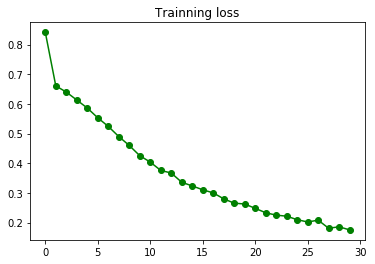

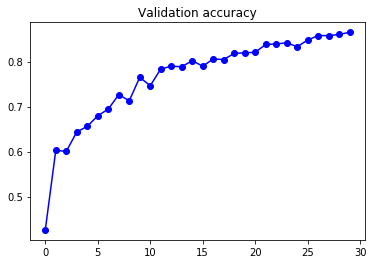

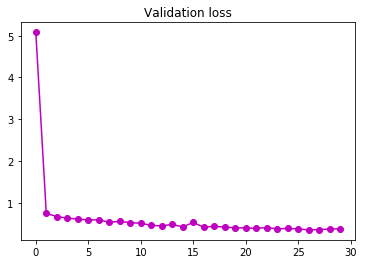

In [35]:
plot_acc_and_loss(hist_resnet)

In [36]:
predictions = model_resnet.predict(X_val)
y_val1 = np.argmax(y_val, axis=-1)
predictions = np.argmax(predictions, axis=-1)
c = confusion_matrix(y_val1, predictions)
print('Confusion matrix:\n', c)
print('sensitivity', c[0, 0] / (c[0, 1] + c[0, 0]))
print('specificity', c[1, 1] / (c[1, 1] + c[1, 0]))

Confusion matrix:
 [[404  64]
 [ 45 295]]
sensitivity 0.8632478632478633
specificity 0.8676470588235294
